<a href="https://colab.research.google.com/github/nabeel-gulzar/sentiment_analysis_ngram/blob/main/sentiment_analysis_uni_bi_pos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis
[Twitter](https://twitter.com/) is a popular microblog service where people can post information and opinions on any topic. For this assignment, you will use tweets about Apple corporation that were extracted from a Twitter dataset created by Sanders Analytics. You can also use the [Twitter api](https://developer.twitter.com/en/docs) for extracting tweets
to create your own dataset.

We will divide this task into the following two sub tasks:
<ul>
<li>The first sub task is binary sentiment classification, for this you will use the  twitter-sanders-apple2.csv file that contains 479 tweets. It has two categories: 
    <ul>
        <li>Pos: Tweets that express a positive or favorable sentiment (Count=163)</li>
        <li>Neg: Tweets that express a negative or unfavorable sentiment (Count=316)</li>
    </ul>
</li>
<br><br>    
<li>The second sub task is binary sentiment classification, for this you will use the  file twitter-sanders-apple3.csv contains 988 tweets. It has three categories: 
    <ul>
        <li>Pos: Tweets that express a positive or favorable sentiment (Count=163)</li>
        <li>Neg: Tweets that express a negative or unfavorable sentiment (Count=316)</li>
        <li>Neutral: tweets that do not express a sentiment (Count=509)</li>
    </ul>
</li>
</ul>


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sn
import pandas as pd
import numpy as np
import csv
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk import pos_tag

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Step 1: Load the data
For this you can use python built in file reader to load the data, you will have to split each row to create list of Tweets(X) and list of sentiment Labels(Y). An alternate option is to use [Pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) to load the csv file, then return the two cols in pandas dataframe as arrays.

In [ ]:

def load_data(filename):
  """
  Load data from file

  Args:
      filename : Name of the file from which the data is to be loaded
  
  Returns: tweet_X, sentiment_Y
  tweet_X: list of tweets
  sentiment_Y: list of sentiment lables correponding to each tweet
  """
  tweets, labels = [], []
  with open(filename) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    row_count = 0
    for row in csv_reader:
      if row_count == 0:
        row_count += 1
        continue
      labels.append(row[0])
      tweets.append(row[1])
  return tweets, labels
tweet_X_task1, sentiment_label_Y_task1=load_data("twitter-sanders-apple2.csv")
tweet_X_task2, sentiment_label_Y_task2=load_data("twitter-sanders-apple3.csv")

### Step 2: Preprocessing
Before we move on to the actual classification section, there is some data cleaning up to be done. As a matter of fact, this step is critical, as it ultimately effects the learning process of your model. 

We will keep to simple preprocessing to make out task easier. Some of you might disagree with the preprocessing steps stated below, hence we wish to mention that choosing different preprocessing steps depend on the nature of task at hand and alos that there are always trade offs associated augmenting the orignal dataset.<br>

You are required to perform the following preprocessing steps:<br>
<i>(note that you must figure out the order of steps for ease of preprocessing yourself)</i><br>
<ul>
    <li><b>Remove all punctuations.</b><br> Although this makes things simple it is not always a good idea to remove punctuation for example in sentiment classification the use of exclaimation marks, can be used to intensify the sentiment of a given word or sentence hence might be useful, nevertheless it increases the vocabulary size hence we will not use it here. e.g. <blockquote>The opening ceremony was extreamly disappointing!!! #PSL5</blockquote>
        Removing pucntutations also removes emojis which might also be helpful.
    </li><br>
    <li><b>Remove all html tags.</b><br> Mostly done for all tasks </li><br>
    <li><b>Replace all @sometext with AT_TOKEN.</b><br>Since there will be lots of different usernames or words that can follow @ we will choose to ignore them as they dont have much sentiment information. Might be usefull for Named Entity Recognition </li>e.g. 
    <blockquote>@apple will be converted to AT_TOKEN</blockquote>
    <li><b>Remove all # symbols.</b> We want to remove the # in #applesucks so that it is not treated differently that any other word in the sentence, this migh also help us to reduce our vocabulary size.</li><br>
    <li><b>Convert the tweets to lower case text</b><br> Although all CAPS convey meaningful information for sentiment analysis we mostly convert text to lower case to reduce vocabulary size by reducing the number of variations. For example Car, cAr ,CAR, caR and car will now be treated as a single token car.</li><br>
    <li><b>Tokenize the text</b><br></li><br>
</ul>    
    

In [ ]:
def preprocessing(data):
  """
  Perform preprocessing of the tweets

  Args:
      data : list of tweets

  Returns: data: preprocessed list of tweets
  """

  reg_html = r'<[^>]+>'
  wo_html_data = [re.sub(reg_html, ' ', data_point).lower() for data_point in data]

  reg_punct = r'[!"#$%&\'()*+,-./:;<=>?\\^_`{|}~]'
  wo_punct_data = [re.sub(reg_punct, ' ', data_point) for data_point in wo_html_data]

  reg_username = r'@[^ ]+'
  return [word_tokenize(re.sub(reg_username, 'AT_TOKEN', data_point)) for data_point in wo_punct_data]

tweet_X_task1=preprocessing(tweet_X_task1)
tweet_X_task2=preprocessing(tweet_X_task2)   

## Step 3: Feature Extraction
For feature extraction you  will  need  a  way  of  mapping  from  sentences  (lists  of  strings)  to  featurevectors, a process called feature extraction or featurization.<br>
For feature vectors we will explore four techniques:
<ul>
    <li><b>Unigram feature vector</b>
        <br> This will be a sparse vector with length equal to the vocabulary size.   It is sparse because a sentence generally contains only 20-40 unique words, so only this many positions in the vector will be nonzero.
</li><br>
    <li><b>Bigram feature vector</b><br>
    The number of unique bigrams will be significantly lower that unigrams, but this will also be sparse.</li><br>
    <li><b>POS features</b>
    Instead of using the words we will use POS tags, this will be generally not as sparse as unigram and bigram, you can use nltk to get POS tags for a sentence, here the featurevectors length will be equal to the total number of unique POS tags.</li><br>
    <li><b>Complex features</b>
    These can be a combination of unigrams and bigrams or any other complex feature that you can think of, we will explore these in later part of the assignment.</li><br>
</ul>

Firstly we need the extract the vocabulary for each of these different feature vectors.<br> 
For this task use [nltk](https://www.nltk.org/)


In [ ]:
def vocabulary_unigram(data):
    """
    Returns list of unique unigrams

    Args:
        data : list of tweets
    
    Returns: vocab_unigram: list of unique unigrams
    """
    vocab = []
    for grams in [ngrams(dp, 1) for dp in data]:
      vocab += [" ".join(gram) for gram in grams]
    return list(set(vocab))

def vocabulary_bigram(data):
    """
    Returns list of unique bigrams

    Args:
        data : list of tweets
    
    Returns: vocab_unigram: list of unique bigrams
    """
    vocab = []
    for grams in [ngrams(dp, 2) for dp in data]:
      vocab += [" ".join(gram) for gram in grams]
    return list(set(vocab))

def vocabulary_POS(data):
    """
    Returns list of unique POS tags

    Args:
        data : list of tweets
    
    Returns: vocab_unigram: list of unique POS tags
    """
    nltk.download('averaged_perceptron_tagger')
    pos_tags = set()
    for sample in data:
      for word, tag in pos_tag(sample):
        pos_tags.add(tag)
    return list(pos_tags)

vocab_unigram_task1=vocabulary_unigram(tweet_X_task1)
vocab_bigram_task1=vocabulary_bigram(tweet_X_task1)
vocab_pos_tag_task1=vocabulary_POS(tweet_X_task1)

vocab_unigram_task2=vocabulary_unigram(tweet_X_task2)
vocab_bigram_task2=vocabulary_bigram(tweet_X_task2)
vocab_pos_tag_task2=vocabulary_POS(tweet_X_task2)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
print(len(vocab_unigram_task1))
print(len(vocab_bigram_task1))
print(len(vocab_pos_tag_task1))

print(len(vocab_unigram_task2))
print(len(vocab_bigram_task2))
print(len(vocab_pos_tag_task2))

1885
5715
32
3141
10313
32


### Creating the feature vector
The feature vector that is to be created is in the following format:e.g.
<blockquote>{'simplistic': False, 'silly': True, 'and': True, 'tedious': False, 'its': False, 'so': True, 'laddish': False, 'juvenile': False, 'only': False, 'teenage': False, 'boys': False, 'could': False, 'possibly': False, 'find': False, 'it': False, 'funny': False, 'exploitative': False, 'largely': False, 'devoid': False}</blockquote><br>
Instructions on how to make the feature vectors:
<ul>
    <li><b>For each tweet</b> the feature vector to be constructed will be equal to the <b>size of the vocabulary</b>.</li>
    <li>The feature vector is a dictionary with <b>word and boolean pairs</b>, here the boolean will be <b>true</b> if the specific word exists in the tweet otherwise it will be <b>false</b>.</li>
    
</ul>


In [ ]:
def features_unigram(data,vocab):
    """
    Returns list of feature vectors

    Args:
        data : list of tweets
    
    Returns: vocab_unigram: list of unique unigrams
    """

    n = len(vocab)
    features = np.zeros((len(data), n))

    for datapoint_idx, datapoint in enumerate(data):
      sample = set(datapoint)
      for vocab_idx, v_word in enumerate(vocab):
        if v_word in sample:
          features[datapoint_idx][vocab_idx] = 1
    return features

def features_bigram(data,vocab):
    """
    Returns list of unique bigrams

    Args:
        data : list of tweets
    
    Returns: vocab_unigram: list of unique bigrams
    """
    n = len(vocab)
    features = np.zeros((len(data), n))

    for datapoint_idx, datapoint in enumerate(data):
      sample = set([" ".join(gram) for gram in ngrams(datapoint, 2)])
      for vocab_idx, v_word in enumerate(vocab):
        if v_word in sample:
          features[datapoint_idx][vocab_idx] = 1

    return features

def features_POS(data,vocab):
    """
    Returns list of unique POS tags

    Args:
        data : list of tweets
    
    Returns: vocab_unigram: list of unique POS tags
    """
    n = len(vocab)
    features = np.zeros((len(data), n))

    for datapoint_idx, datapoint in enumerate(data):
      sample = set([tag for _, tag in pos_tag(datapoint)])
      for vocab_idx, v_item in enumerate(vocab):
        if v_item in sample:
          features[datapoint_idx][vocab_idx] = 1
    return features


task1_unigram_features=features_unigram(tweet_X_task1,vocab_unigram_task1)
task1_bigram_features=features_bigram(tweet_X_task1,vocab_bigram_task1)
task1_POS_features=features_POS(tweet_X_task1,vocab_pos_tag_task1)

task2_unigram_features=features_unigram(tweet_X_task2,vocab_unigram_task2)
task2_bigram_features=features_bigram(tweet_X_task2,vocab_bigram_task2)
task2_POS_features=features_POS(tweet_X_task2,vocab_pos_tag_task2)

In [ ]:
np.sum(task1_bigram_features, axis=1).mean()

17.022964509394573

### Step 4: Test Train Split
Test train split, use [sklearns test train split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the data into 80-20 ratio for training and testing. Here we are not using validation set as our dataset is too small.
<blockquote>Note: The lists for labels are overwritten beacause each split should return the same labels</blockquote>

In [ ]:
def test_train_split(featurevectors,labels):
    """
    Returns test train split data

    Args:
        featurevectors : list of feature vectors
    
    Returns: feature_vector_train, feature_vector_test, label_train, label_test
    """
    X_train, X_test, y_train, y_test = train_test_split(featurevectors, labels, test_size=0.2, random_state=50)
    return X_train, X_test, y_train, y_test

task1_unigram_features_train, task1_unigram_features_test, task1_label_train, task1_label_test=test_train_split(task1_unigram_features, sentiment_label_Y_task1)

task1_bigram_features_train, task1_bigram_features_test, task1_label_train, task1_label_test=test_train_split(task1_bigram_features, sentiment_label_Y_task1)

task1_POS_features_train, task1_POS_features_test, task1_label_train, task1_label_test=test_train_split(task1_POS_features, sentiment_label_Y_task1)


task2_unigram_features_train, task2_unigram_features_test, task2_label_train, task2_label_test=test_train_split(task2_unigram_features, sentiment_label_Y_task2)

task2_bigram_features_train, task2_bigram_features_test, task2_label_train, task2_label_test=test_train_split(task2_bigram_features, sentiment_label_Y_task2)

task2_POS_features_train, task2_POS_features_test, task2_label_train, task2_label_test=test_train_split(task2_POS_features, sentiment_label_Y_task2)

### Step 5: Modelling and Predictions 

#### Model 1: Niave Bayes
For the purpose of classification we will use [Niave Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) from sklearn. Train the Niave Bayes algorithm on all featurevector variants of task 1 and task 2.<br>
In order to compare and quantify the goodness of our model we will compute a [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html). We will also create a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to see what mistakes the model might be making.

First program the train_model and predictions function which are general functions that will be used later on.

In [ ]:
def train_model(model,features,labels):
    """
    Trains a Naive Bayes model 

    Args:
        features : list of feature vectors or X
        labels: targets or Y
        model: Niave Bayes model that is to be trained
    
    Returns: trained model
    """
    model.fit(features, labels)
    return model

In [ ]:
def predictions(model,features):
    """
    Returns predictions from a trained model

    Args:
        features : list of feature vectors or X
        model: Niave Bayes model that is to be trained
    
    Returns: prediction list
    """
    return model.predict(features)

##### Using the above functions train different models for different feature vectors and  obtain the models predictions for test set.

In [ ]:
#train model on task1_unigram_features_train
###__________Code_Here________________###
# task1_unigram_features_train, task1_unigram_features_test, task1_label_train, task1_label_test
clf = MultinomialNB()
model = train_model(clf, task1_unigram_features_train, task1_label_train)

###___________________________________###

              precision    recall  f1-score   support

         Pos       0.79      0.58      0.67        38
         Neg       0.76      0.90      0.83        58

    accuracy                           0.77        96
   macro avg       0.78      0.74      0.75        96
weighted avg       0.77      0.77      0.76        96



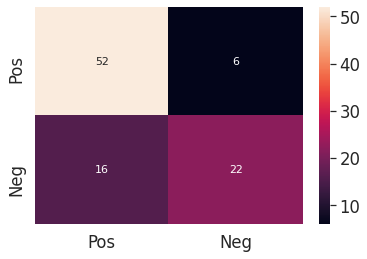

In [ ]:
#Classification report for task1_unigram_features_train
###__________Code_Here________________###
pred = predictions(model, task1_unigram_features_test)
###___________________________________###

print(classification_report(task1_label_test, pred, labels=["Pos", "Neg"]))
cm=confusion_matrix(task1_label_test,pred)
cm = pd.DataFrame(cm, ['Pos','Neg'], ['Pos','Neg'])# matrix,names row,names col,
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.5) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt="d") # font size
plt.show()

In [ ]:
#train model on task1_bigram_features_train
###__________Code_Here________________###
# task1_bigram_features_train, task1_bigram_features_test, task1_label_train, task1_label_test
model = MultinomialNB()
model = train_model(model, task1_bigram_features_train, task1_label_train)

###___________________________________###

              precision    recall  f1-score   support

         Pos       0.48      0.82      0.61        38
         Neg       0.78      0.43      0.56        58

    accuracy                           0.58        96
   macro avg       0.63      0.62      0.58        96
weighted avg       0.66      0.58      0.58        96



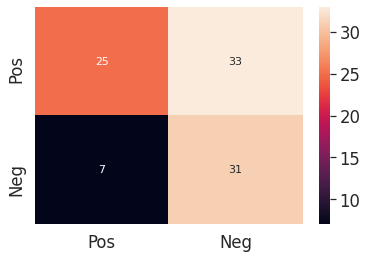

In [ ]:
#Classification report and confusion matrix for task1_bigram_features_train
###__________Code_Here________________###
pred=predictions(model, task1_bigram_features_test)
###___________________________________###

print(classification_report(task1_label_test, pred, labels=["Pos", "Neg"]))
cm=confusion_matrix(task1_label_test,pred)
cm = pd.DataFrame(cm, ['Pos','Neg'], ['Pos','Neg'])# matrix,names row,names col,
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.5) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt="d") # font size
plt.show()

In [ ]:
#train model on task1_POS_features_train
###__________Code_Here________________###
# task1_POS_features_train, task1_POS_features_test, task1_label_train, task1_label_test
model = MultinomialNB()
model = train_model(model, task1_POS_features_train, task1_label_train)

###___________________________________###

              precision    recall  f1-score   support

         Pos       0.67      0.11      0.18        38
         Neg       0.62      0.97      0.76        58

    accuracy                           0.62        96
   macro avg       0.64      0.54      0.47        96
weighted avg       0.64      0.62      0.53        96



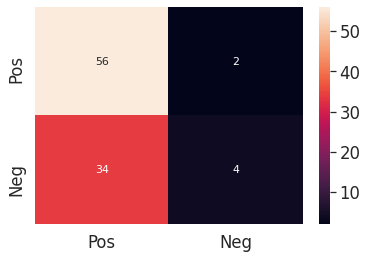

In [ ]:
#Classification report for task1_POS_features
###__________Code_Here________________###
pred=predictions(model, task1_POS_features_test)
###___________________________________###

print(classification_report(task1_label_test, pred, labels=["Pos", "Neg"]))
cm=confusion_matrix(task1_label_test,pred)
cm = pd.DataFrame(cm, ['Pos','Neg'], ['Pos','Neg'])# matrix,names row,names col,
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.5) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt="d") # font size
plt.show()

#### Compare how performance changes for different feature vectors for task1? 

In [ ]:
%%capture
###______________Answer_Start_________###
comparison = 'When we used unigram the f1 when scored was a little higher compared to when we used bigram. \
              The reason for that might be the corpus size. As we are using a smaller corpus we are geting unigram \
              better than the bigram because bigram seems to work better with much larger corpus. \
              In case POS the f1 is similar to that in bigram. This seems to beacuse the kind of task we are trying \
              to do does not get much information from part of speach. It requires the actual word. So in this setting POS \
              is not a good choice.'
###______________Answer_End_________###

##### Repeat the above steps for task2

In [ ]:
#train model on task2_unigram_features_train
###__________Code_Here________________###
# task1_unigram_features_train, task1_unigram_features_test, task1_label_train, task1_label_test
model = MultinomialNB()
model = train_model(model, task2_unigram_features_train, task2_label_train)

###___________________________________###

              precision    recall  f1-score   support

         Pos       0.70      0.23      0.35        30
         Neg       0.57      0.86      0.68        58
     Neutral       0.80      0.73      0.76       110

    accuracy                           0.69       198
   macro avg       0.69      0.61      0.60       198
weighted avg       0.72      0.69      0.68       198



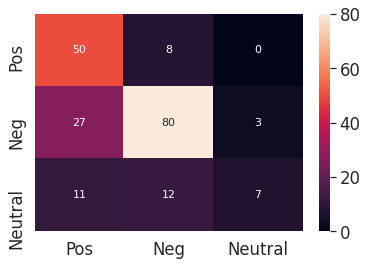

In [ ]:
#Classification report for task2_unigram_features
###__________Code_Here________________###
pred=predictions(model, task2_unigram_features_test)
###___________________________________###
print(classification_report(task2_label_test, pred, labels=["Pos", "Neg","Neutral"]))
cm=confusion_matrix(task2_label_test,pred)
cm = pd.DataFrame(cm, ["Pos","Neg","Neutral"], ["Pos","Neg","Neutral"])# matrix,names row,names col,
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.5) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt="d") # font size
plt.show()

In [ ]:
#train model on task2_bigram_features_train
###__________Code_Here________________###
# task1_bigram_features_train, task1_bigram_features_test, task1_label_train, task1_label_test
model = MultinomialNB()
model = train_model(model, task2_bigram_features_train, task2_label_train)

###___________________________________###

              precision    recall  f1-score   support

         Pos       0.29      0.53      0.37        30
         Neg       0.60      0.59      0.59        58
     Neutral       0.79      0.61      0.69       110

    accuracy                           0.59       198
   macro avg       0.56      0.58      0.55       198
weighted avg       0.66      0.59      0.61       198



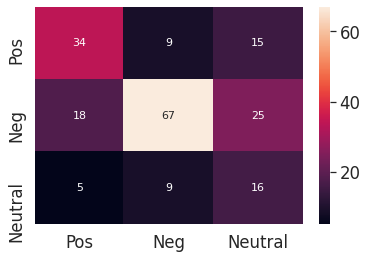

In [ ]:
#Classification report for task2_bigram_features
###__________Code_Here________________###
pred=predictions(model, task2_bigram_features_test)
###___________________________________###

print(classification_report(task2_label_test, pred, labels=["Pos", "Neg","Neutral"]))
cm=confusion_matrix(task2_label_test,pred)
cm = pd.DataFrame(cm, ["Pos","Neg","Neutral"], ["Pos","Neg","Neutral"])# matrix,names row,names col,
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.5) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt="d") # font size
plt.show()

In [ ]:
#train model on task2_POS_features_train
###__________Code_Here________________###
# task2_POS_features_train, task2_POS_features_test, task2_label_train, task2_label_test
model = MultinomialNB()
model = train_model(model, task2_POS_features_train, task2_label_train)

###___________________________________###

              precision    recall  f1-score   support

         Pos       0.40      0.07      0.11        30
         Neg       0.47      0.28      0.35        58
     Neutral       0.60      0.87      0.71       110

    accuracy                           0.58       198
   macro avg       0.49      0.41      0.39       198
weighted avg       0.53      0.58      0.52       198



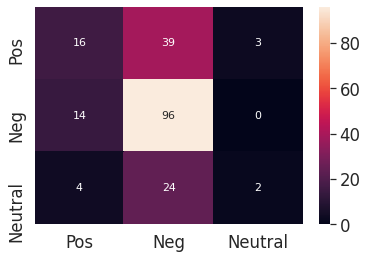

In [ ]:

#Classification report for task2_POS_features
###__________Code_Here________________###
pred=predictions(model, task2_POS_features_test)
###___________________________________###

print(classification_report(task2_label_test, pred, labels=["Pos", "Neg","Neutral"]))
cm=confusion_matrix(task2_label_test,pred)
cm = pd.DataFrame(cm, ["Pos","Neg","Neutral"], ["Pos","Neg","Neutral"])# matrix,names row,names col,
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.5) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt="d") # font size
plt.show()

#####  How does the addition of an extra class affect the learning of our algorithm? Which pairs of classes are most often confused? Why might that be? 

In [ ]:
%%capture
###______________Answer_Start_________###
comparison = 'When we used unigram the f1 when scored was a just a little higher compared to when we used bigram. \
              but the result of POS was significantly lower, meaning that the part of speach does not really play a part \
              in deciding the outcome here, which is the sentiment. Maybe if we combined the POS tag with n-gram we can get \
              the good results. \
              negative class is often confused as postive or neutral. The reason could be the presense of similar kind \
              of words in confised classes. Increasing the data might be helpful becasue using the current data the model \
              is unable to succesfully predict the sentiment. \
              Adding another class did not affect the training as the probablities are computed conditionally, given a \
              particular class. Although the count of samples with lable neutral is much larger but we are also multiplying \
              with the prior, which is the probabbility of the particular class.'
###______________Answer_End_________###

### We can further create more complex features by combining different ngram features to  improve performance. We can also remove words that occur rarely in our dataset to reduce the size of our feature vectors. 

#### Model2: Logistic Regression
We will now use [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to explore the improvements stated above. To create complex feature vectors we will use [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) from sklearn.<br>
We will play around with two parameters of CountVectorizer:
<ul>
    <li>min_df ( = 5): defines the minimum frequency of a word for it to be counted as a feature, in this case the word should have a frequency count of atleast 5.</li>
    <li>ngram_range (= (2,2)): The ngram_range parameter is a tuple. It defines the minimum and maximum length of sequence of tokens considered. In this case, this length is 2. So, this will find sequence of 2 tokens like — ‘but the’, ‘wise man’ etc.</li>
</ul>
Use the ngram_range=(1,2) and min_df=5.

Hint: See the fit and transform functions<br>

    

    

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#create complex features
###__________Code_Here________________###
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=5)
task2_complex_features = vectorizer.fit_transform([" ".join(t) for t in tweet_X_task2])
task2_complex_features_train, task2_complex_features_test, task2_label_train, task2_label_test=test_train_split(task2_complex_features, sentiment_label_Y_task2)

###___________________________________###

In [ ]:
#train logistic regression model
###__________Code_Here________________###
model = LogisticRegression()
model = train_model(model, task2_complex_features_train, task2_label_train)

###___________________________________###

              precision    recall  f1-score   support

         Pos       0.52      0.37      0.43        30
         Neg       0.58      0.62      0.60        58
     Neutral       0.72      0.75      0.74       110

    accuracy                           0.66       198
   macro avg       0.61      0.58      0.59       198
weighted avg       0.65      0.66      0.65       198



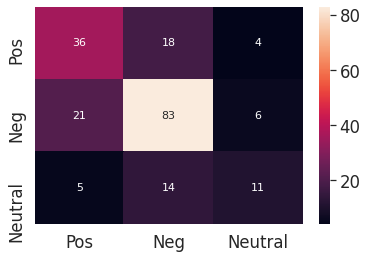

In [ ]:
#train model on complex_feature
###__________Code_Here________________###
pred = predictions(model, task2_complex_features_test)
###___________________________________###

print(classification_report(task2_label_test, pred, labels=["Pos", "Neg","Neutral"]))
cm=confusion_matrix(task2_label_test,pred)
cm = pd.DataFrame(cm, ["Pos","Neg","Neutral"], ["Pos","Neg","Neutral"])# matrix,names row,names col,
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.5) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt="d") # font size
plt.show()

#### You can play around with ngram_range and min_df to further improve performance. 
